In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 1.1 Birth Rates

The data on US births, provided by the CDC is in `data/births.csv`.

Reproduce the following plot of births by gender over time given the data:

![](births_gender.png)

Note the `1e6` on the y axis for scale

In [2]:
df = pd.read_csv('data/births.csv')


In [3]:
df_births = df.groupby(['year','gender']).sum()[['births']].reset_index(level=[0]).reset_index()


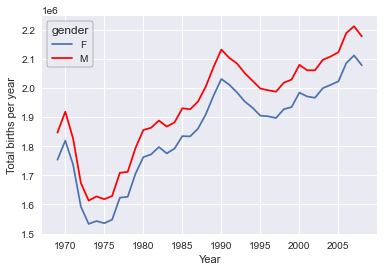

In [4]:
mpl.style.use('seaborn')
fig, ax = plt.subplots(figsize = (6,4))
xf = df_births[df_births['gender']=='F']['year'] 
yf = df_births[df_births['gender']=='F']['births']
xm = df_births[df_births['gender']=='M']['year']
ym = df_births[df_births['gender']=='M']['births']
ax.plot(xf, yf, label = 'F')
ax.plot(xm, ym, label = 'M', color = 'red')
plt.xlabel('Year')
plt.ylabel('Total births per year')
lg = ax.legend(title='gender', fontsize = '10', frameon= True, edgecolor = 'black')
title = lg.get_title().set_fontsize(12)
plt.show()

# 1.2 Births anomalies

This was analyzed by beloved statistician Andrew Gelman [here](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/), leading to this plot:

![](births_gp100.png)

Explain all three plots in Gelman's figure. 

**1.2:** What is the periodic component? What is the residual? Use your research skills to learn then explain it (in english).

1.2.1 Figure 1 represents the variation of the ratio of the average number of births for each day in a year over the average number of births over all the days of a year

1.2.2 Periodic cycle

1.2.3 Difference between actual and periodic component

# 1.3 Holiday Anomalies Plot

Reproduce *as best you can* the first of the 3 figures from Andrew Gelman's blog post (your plot may have small differences)

**1.3.1:** Reproduce the births line in a plot. Hint: Make the x axis a `pd.datetime` object

**1.3.2:** Reproduce the `smoothed` line. Hint: use a rolling window average

**1.3.3:** Reproduce the entire figure with the mean line as a horizontal. You can make the y axis total births instead of a % deviation from mean axis (they'll look the same anyway)

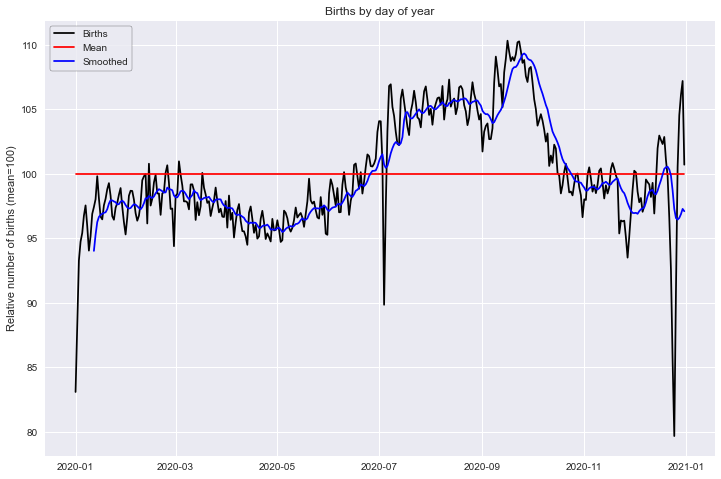

In [5]:
# pd.set_option('display.max_rows', None)

#remove na and days greater than 31
df1_3 = df[(df['day'].notna()) & (df['day']<=31.0)]

#remove data of february 29th that is incomplete
feb_29_to_keep = [y for y in range(1972, 1988, 4)]
mask_2_29 = (df1_3['month']==2) & (df1_3['day']==29) & (~df1_3['year'].isin(feb_29_to_keep))
df1_3 = df1_3[~mask_2_29]

#remove data of dates which do not exist
months_31 = [2,4,6,9,11] 
mask_31 = (df1_3['day']==31) & (df1_3['month'].isin(months_31))
df1_3 = df1_3[~mask_31]

mask_2_30 = ((df1_3['day']==30) & (df1_3['month']==2))
df1_3 = df1_3[~mask_2_30]

#Mean birth rate 
df1_3_mean = df1_3['births'].mean()

#Average birth rate for each day of the year
df1_3_group = df1_3.groupby(['month', 'day']).mean().reset_index(level=[0]).reset_index()

#Convert to a datetime
d = {'1':'01', '2':'02', '3':'03', '4':'04', '5':'05', '6':'06', '7':'07', '8':'08', '9':'09' }
df1_3_group['day'] = df1_3_group['day'].astype('int')
df1_3_group['time'] = '2020-'+df1_3_group['month'].astype(str).replace(d)+ '-' + df1_3_group['day'].astype(str).replace(d)
df1_3_group['time'] = pd.to_datetime(df1_3_group['time'], format='%Y-%m-%d')

#Calculations
df1_3_group['relative num births'] = df1_3_group['births']/df1_3_mean*100
df1_3_group['mean'] = 100

#Rolling average
df1_3_roll = df1_3_group[['time','relative num births']].set_index('time')
df1_3_roll = df1_3_roll.rolling(12, closed='right').mean()

#Graph
#relative number of birth for each day of the year
x = df1_3_group['time']
y = df1_3_group['relative num births']

#relative mean birth for each day of the year
x_mean = df1_3_group['time']
y_mean = df1_3_group['mean']

#Moving average
x_rolling = df1_3_roll.index
y_rolling = df1_3_roll['relative num births']

#Graph
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(x,y, color = 'black', label = 'Births')
ax.plot(x_mean,y_mean, color = 'red', label = 'Mean')
ax.plot(x_rolling ,y_rolling, color = 'blue',label = 'Smoothed')
ax.set_ylabel('Relative number of births (mean=100)')
ax.set(title = 'Births by day of year')
ax.legend(loc = 'upper left' , frameon= True, edgecolor= 'black')
plt.show()

# 2. Recipe Database

### 2.1 

Load the JSON recipe database we saw in lecture 4.

How many of the recipes are for breakfast food? Hint: The `description` would contain the work "breakfast"

In [6]:
import gzip

with gzip.open('data/recipe.json.gz', 'r') as f:
    data = (line.strip().decode() for line in f)
    data_json = f"[{','.join(data)}]"
recipes = pd.read_json(data_json)
recipes2_2 = recipes

In [7]:
mask_desc = ~recipes['description'].isna()
recipes = recipes[mask_desc]
mask_bf = recipes['description'].apply(lambda x: x.lower()).str.contains('breakfast')
breakfast = recipes[mask_bf]
print(f'Answer 2.1: There are at least {len(breakfast)} recipes for breakfast. ')


Answer 2.1: There are at least 3524 recipes for breakfast. 


### 2.2 A simple recipe recommender

Let's build a recipe recommender: given a list of basic ingredients, find a recipe that uses all those ingredients.

Here is the list of ingredients that can be asked for:

```
['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
```

**Hint:** Build a new column for each of the ingredients that indicates whether that ingredient is in the recipe.

**example:**
```
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

result: 
# The rows where these 3 ingredients are in the recipe
[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]
```

In [8]:
def recipe_recommender(lst_ingredients, df):
    '''
    Functions which takes in a list of ingredients and returns the index of the recipes which include all of the ingredients.
    
    Input:
    lst_ingredients: List of ingredients
    df: dataframe which contains the recipes
    '''

    for i in lst_ingredients:
        df[i] = df['ingredients'].apply(lambda x: x.lower()).str.contains(i)
    mask = df[lst_ingredients].all(axis= 1)
    df = df[mask]
    return f'Result:\nThe rows where these {len(lst_ingredients)} ingredients are in the recipe {list(df.index)}'

In [9]:
list_ingredients = ["parsley", "paprika", "tarragon"]
print(recipe_recommender(list_ingredients, recipes2_2))

Result:
The rows where these 3 ingredients are in the recipe [2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 162896, 163175, 165243, 171774]


# 3. Movies!

Recall the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) from lecture 4. It's made up of several tables which we've played with in lecture 4.

The tables have common columns (`id` and `movie_id`) around which you can merge and join tables.

### 3.1 best director

Your task is to find **The best director** in terms of average ratings of his movies. This can be from the `ratings` or `ratings_small` table, or simply the vote average in the `metadata` table. The director can be found in the `cast` table.

You will have to use all of your skills to get this done, between using groupbys and merging multiple tables together

In [10]:
df_credits = pd.read_csv('data/archive/credits.csv')
df_movies = pd.read_csv('data/archive/movies_metadata.csv')


C:\Users\education\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
df_credits.crew = df_credits.crew.apply(eval)

In [12]:
def find_director(credit_crew):
    dir_name = None
    for info in credit_crew:
        if info['job'] == 'Director':
            dir_name = info['name']
    return dir_name

df_credits['director_name'] = df_credits.crew.apply(find_director)


In [13]:
df_id_directors = df_credits[['id', 'director_name']]
df_id_directors= df_id_directors.astype({"id": str})
df_id_ratings= df_movies[['id', 'vote_average' ]]
df_merge = pd.merge(df_id_directors, df_id_ratings, on = 'id')
df_best_director = df_merge.groupby('director_name').mean().reset_index().sort_values('vote_average', ascending = False)
df_best_director = df_best_director[df_best_director['vote_average']==10.0]
print('Best directors: ')
df_best_director 

Best directors: 


,director_name,vote_average
2039,Brandon Chesbro,10.0
10393,Lukas Bossuyt,10.0
6416,Henwar Rodakiewicz,10.0
15990,Steven Lewis Simpson,10.0
9388,Kentaro Hagiwara,10.0
...,...,...
16682,Todd Grimes,10.0
7372,Jason Baffa,10.0
7314,Jane Howell,10.0
3214,Cris Jones,10.0
